In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
import matplotlib.gridspec as gridspec

import sys
sys.path.append('../src')  # Go one level up and then into src
from SMF import SMF_BCD, SMF_LPGD, rank_r_projection, compute_accuracy_metrics
from SMF_torch import smf

# Microarray Cancer Data

## Read data

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_style("whitegrid")

#sys.path.append('../data')  # Go one level up and then into src

"""
data = pd.read_csv('../Data/Breast_GSE70947.csv')
y = data['type'].values
y = [1 if y[i] == 'breast_adenocarcinoma' else 0 for i in range(len(y))]
X = data.drop(columns=['samples', 'type']).values
X = (X - np.mean(X, axis = 0))/(100*np.std(X, axis = 0)) # normalization
print("X.shape=", X.shape)

"""

data = pd.read_csv('../Data/Pancreatic_GSE16515.csv')
y = data['type'].values
y = [1 if y[i] == 'tumoral' else 0 for i in range(len(y))]
y = np.array(y)
X0 = data.drop(columns=['samples', 'type']).values
X = (X0 - np.mean(X0, axis = 0))/(100*np.std(X0, axis = 0)) # normalization
#X = 10*X0/np.linalg.norm(X0)
print("X.shape=", X.shape) # X.shape = [num of samples, num of features]
print("y.shape=", y.shape)


X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train, X_test = X_train.T, X_test.T
Y_train, Y_test = np.asarray([Y_train]), np.asarray([Y_test])
covariate_train, covariate_test = None, None

gene_list0 = data.keys()
gene_list = gene_list0[2:]

X.shape= (51, 54675)
y.shape= (51,)


## SMF-W

### Use Block Coordiante Descent to fit SMF-W

In [ ]:
r = 2 # number of latent gene groups
xi = 1 # supervision parameter (weight for the matrix factorization loss)
iteration = 100


U0, S0, H0, recons = rank_r_projection(X_train, r)
W0 = U0 @ np.diag(S0) # initial filters = latent gene groups 
W0 = [W0, 1-2*np.random.rand(Y_train.shape[0], r + 1)] # initial filters + regression coefficients

SMF_BCD_class = SMF_BCD(X=[X_train, Y_train],  # data, label
                            X_test=[X_test, Y_test], 
                            n_components=r,  
                            ini_loading=W0,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                            # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                            ini_code = H0,
                            xi=xi,  # weight on label reconstruction error
                            nonnegativity=[False,False,False]) # nonnegativity constraints on code H, dictionary W[0], reg params W[1]

results_dict = SMF_BCD_class.fit(iter=iteration, subsample_size=None,
                                    option = "filter",
                                    if_compute_recons_error=True, if_validate=False)

results_dict.update({'method': 'SMF-W'})
results_dict.update({'r': r})
results_dict.update({'xi': xi})
results_dict.update({'nu': None})

initial loading beta [[0.47151997 0.35530941 0.64547285]]


  4%|▍         | 4/100 [00:00<00:02, 35.18it/s]

--- Training --- [threshold, AUC] =  [np.float64(0.74), np.float64(0.917)]
--- Iteration 0: Training loss --- [Data, Label, Total] = [94.647521.3, 10.400636.3, 105.048158.3]


 11%|█         | 11/100 [00:00<00:01, 46.26it/s]

--- Training --- [threshold, AUC] =  [np.float64(0.642), np.float64(0.931)]
--- Iteration 10: Training loss --- [Data, Label, Total] = [89.126799.3, 9.299910.3, 98.426709.3]


 28%|██▊       | 28/100 [00:00<00:01, 53.88it/s]

--- Training --- [threshold, AUC] =  [np.float64(0.641), np.float64(0.944)]
--- Iteration 20: Training loss --- [Data, Label, Total] = [89.359283.3, 8.783899.3, 98.143182.3]
--- Training --- [threshold, AUC] =  [np.float64(0.565), np.float64(0.951)]
--- Iteration 30: Training loss --- [Data, Label, Total] = [89.530398.3, 8.434581.3, 97.964979.3]


 46%|████▌     | 46/100 [00:00<00:01, 49.75it/s]

--- Training --- [threshold, AUC] =  [np.float64(0.566), np.float64(0.951)]
--- Iteration 40: Training loss --- [Data, Label, Total] = [89.655905.3, 8.185471.3, 97.841376.3]
--- Training --- [threshold, AUC] =  [np.float64(0.568), np.float64(0.951)]
--- Iteration 50: Training loss --- [Data, Label, Total] = [89.750818.3, 8.000665.3, 97.751483.3]


 71%|███████   | 71/100 [00:01<00:00, 51.00it/s]

--- Training --- [threshold, AUC] =  [np.float64(0.568), np.float64(0.958)]
--- Iteration 60: Training loss --- [Data, Label, Total] = [89.824731.3, 7.859105.3, 97.683836.3]
--- Training --- [threshold, AUC] =  [np.float64(0.569), np.float64(0.958)]
--- Iteration 70: Training loss --- [Data, Label, Total] = [89.883692.3, 7.747756.3, 97.631448.3]


 90%|█████████ | 90/100 [00:01<00:00, 52.69it/s]

--- Training --- [threshold, AUC] =  [np.float64(0.57), np.float64(0.958)]
--- Iteration 80: Training loss --- [Data, Label, Total] = [89.931575.3, 7.659742.3, 97.591317.3]
--- Training --- [threshold, AUC] =  [np.float64(0.57), np.float64(0.965)]
--- Iteration 90: Training loss --- [Data, Label, Total] = [89.971146.3, 7.586652.3, 97.557798.3]


100%|██████████| 100/100 [00:02<00:00, 49.93it/s]

!!! pred_type filter
--- Training --- [threshold, AUC] =  [np.float64(0.571), np.float64(0.965)]


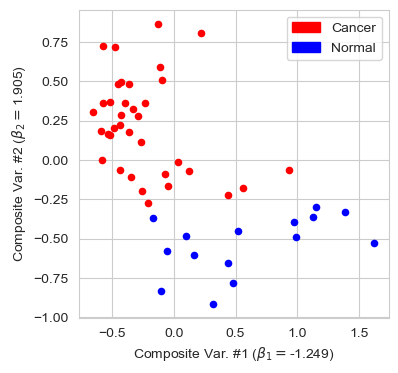

In [ ]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=[4,4], constrained_layout=False)
outer_grid = gridspec.GridSpec(nrows=1, ncols=1, wspace=0, hspace=0)
inner_grid = outer_grid[0,0].subgridspec(1, 1, wspace=0, hspace=0)
ax = fig.add_subplot(inner_grid[0, 0])
colors = ["r", "b"]

W = results_dict.get("loading")[0]
Beta = results_dict.get("loading")[1]
X_comp = W.T @ X.T

for i in np.arange(len(y)):
    x1 = X_comp[0,i]
    x2 = X_comp[1,i]
    label = y[i]
    
    if label == 0:
        ax.scatter(x1, x2, s=20, c="b", alpha=1)
    else:
        ax.scatter(x1, x2, s=20, c="r", alpha=1)
        
red_patch = mpatches.Patch(color='red', label='Cancer')
blue_patch = mpatches.Patch(color='blue', label='Normal')
ax.legend(handles=[red_patch, blue_patch])

beta1 = np.round(Beta[0,1], 3)
beta2 = np.round(Beta[0,2], 3)
ax.set_xlabel(r"Composite Var. #1 ($\beta_{1}=$"+str(beta1) + ")")
ax.set_ylabel(r"Composite Var. #2 ($\beta_{2}=$"+str(beta2) + ")")



plt.savefig("plot1", bbox_inches="tight", dpi=300)

In [ ]:
print("latent gene groups = " + "\n" + "{}".format(W))
print("regression coefficients associated to the latent gene groups = {}".format(Beta[0,1:]))
print("intercept term = {}".format(Beta[0,0]))

latent gene groups = 
[[-3.52264040e-03  7.58152588e-03]
 [-2.59823552e-03  1.41878962e-03]
 [-2.81920269e-03  5.52965620e-03]
 ...
 [ 2.01460038e-03 -9.48611164e-05]
 [ 2.73517196e-03 -2.56584980e-04]
 [ 1.16138669e-03  2.32250207e-03]]
regression coefficients associated to the latent gene groups = [-1.24921488  1.90489837]
intercept term = 0.8437103411567115


### Use Low-rank Projected Gradient Descent to fit SMF-W

In [ ]:
r = 2 # number of latent gene groups
xi = 1 # supervision parameter (weight for the matrix factorization loss)
iteration = 100

U0, S0, H0, recons = rank_r_projection(X_train, r)
W0 = U0 @ np.diag(S0) # initial filters = latent gene groups 
W0 = [W0, 1-2*np.random.rand(Y_train.shape[0], r + 1)] # initial filters + regression coefficients

SMF_LPGD_class = SMF_LPGD(X=[X_train, Y_train],  # data, label
                        X_test=[X_test, Y_test],
                        n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                        ini_loading = W0,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                        # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                        ini_code = H0,
                        xi=xi)  # weight on label reconstruction error
                       

results_dict = SMF_LPGD_class.fit(iter=iteration, 
                                    beta = 0,
                                    nu = 0,
                                    stepsize=0.01,
                                    if_compute_recons_error=False, if_validate=False)

results_dict.update({'method': 'SDL-W'})
results_dict.update({'r': r})
results_dict.update({'xi': xi})
results_dict.update({'nu': None})

initial loading beta [[ 0.08032959 -0.89224803 -0.06860986]]


100%|██████████| 100/100 [00:09<00:00, 10.16it/s]


!!! pred_type filter
--- Training --- [threshold, AUC] =  [np.float64(0.686), np.float64(0.944)]
!!! ACC_list [np.float64(0.8076923076923077)]
--- Validation (filter) --- [threshold, AUC, accuracy, rel_error_data] = [0.595, 0.958, 0.808, 0.854]


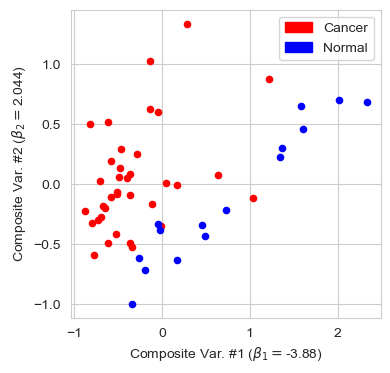

In [ ]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=[4,4], constrained_layout=False)
outer_grid = gridspec.GridSpec(nrows=1, ncols=1, wspace=0, hspace=0)
inner_grid = outer_grid[0,0].subgridspec(1, 1, wspace=0, hspace=0)
ax = fig.add_subplot(inner_grid[0, 0])
colors = ["r", "b"]

W = results_dict.get("loading")[0]
Beta = results_dict.get("loading")[1]
X_comp = W.T @ X.T

for i in np.arange(len(y)):
    x1 = X_comp[0,i]
    x2 = X_comp[1,i]
    label = y[i]
    
    if label == 0:
        ax.scatter(x1, x2, s=20, c="b", alpha=1)
    else:
        ax.scatter(x1, x2, s=20, c="r", alpha=1)
        
red_patch = mpatches.Patch(color='red', label='Cancer')
blue_patch = mpatches.Patch(color='blue', label='Normal')
ax.legend(handles=[red_patch, blue_patch])

beta1 = np.round(Beta[0,1], 3)
beta2 = np.round(Beta[0,2], 3)
ax.set_xlabel(r"Composite Var. #1 ($\beta_{1}=$"+str(beta1) + ")")
ax.set_ylabel(r"Composite Var. #2 ($\beta_{2}=$"+str(beta2) + ")")



plt.savefig("plot2", bbox_inches="tight", dpi=300)

In [ ]:
print("latent gene groups = " + "\n" + "{}".format(W))
print("regression coefficients associated to the latent gene groups = {}".format(Beta[0,1:]))
print("intercept term = {}".format(Beta[0,0]))

latent gene groups = 
[[-0.00267029  0.0042739 ]
 [-0.00394761  0.00013561]
 [-0.00377185  0.00492672]
 ...
 [ 0.00440043 -0.00040135]
 [ 0.00464738  0.0010489 ]
 [ 0.00310083  0.00265626]]
regression coefficients associated to the latent gene groups = [-3.87954256  2.04356157]
intercept term = 0.5364943460140998


### Use Pytorch implementation of BCD to fit SMF-W (utilizes GPU if possible)

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.autograd import Variable

"""
#data = pd.read_csv('../Data/Pancreatic_GSE16515.csv')
data = pd.read_csv('../Data/Breast_GSE70947.csv')

print(data.shape)
y = data['type'].values
y = [1 if y[i] == 'breast_adenocarcinoma' else 0 for i in range(len(y))]
y = np.array(y)
X = data.drop(columns=['samples', 'type']).values
X = (X - np.mean(X, axis = 0))/(100*np.std(X, axis = 0)) # normalization
"""


hidden_size = 2

Accuracy = []
test_size = 0.5

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size, random_state=2)

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(Y_train)).long()
X_test = Variable(torch.from_numpy(X_test)).float()
y_test = Variable(torch.from_numpy(Y_test)).long()
print(f"y_train's ndim: {y_train.ndim}")

smf_model = smf(X_train, y_train, hidden_size, device='cuda')
smf_model.fit(num_epochs=10000,
               lr_classification=0.01,
               lr_matrix_factorization=0.01,
               xi=1,
               initialize='spectral',
               W_nonnegativity=True,
               H_nonnegativity=True,
               test_data=[X_test, y_test],
               record_recons_error=True)
Accuracy.append(smf_model.test(X_test, y_test))

y_train's ndim: 1

x2's shape: torch.Size([25, 1])
x2's shape: torch.Size([25, 1])
x2's shape: torch.Size([25, 1])
x2's shape: torch.Size([25, 1])
x2's shape: torch.Size([25, 1])
x2's shape: torch.Size([25, 1])
x2's shape: torch.Size([25, 1])
x2's shape: torch.Size([25, 1])
x2's shape: torch.Size([25, 1])
x2's shape: torch.Size([25, 1])
Epoch [10/10000],Loss_Classification: 50.3738 Loss_MF: 0.0001
x2's shape: torch.Size([26, 1])
mythre= 0.5
mythre_test= 0.62271804
Test accuracy = 0.846, Test AUC = 0.85
x2's shape: torch.Size([25, 1])
--- Training --- [threshold, AUC] =  [np.float32(0.696), np.float64(0.896)]
--- Iteration 9: Training loss --- [Data, Label, Total] = [98.333855.3, 12.143910.3, 110.477765.3]
x2's shape: torch.Size([25, 1])
x2's shape: torch.Size([25, 1])
x2's shape: torch.Size([25, 1])
x2's shape: torch.Size([25, 1])
x2's shape: torch.Size([25, 1])
x2's shape: torch.Size([25, 1])
x2's shape: torch.Size([25, 1])
x2's shape: torch.Size([25, 1])
x2's shape: torch.Size([25, 1

KeyboardInterrupt: 